In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB

from sklearn.feature_extraction.text import CountVectorizer
from BertClassifier import BertClassifier
from RobertaClassifier import RobertaClassifier
from FunctionUtil import *

from tqdm import tqdm
import os


/opt/homebrew/lib/python3.11/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset = pd.read_csv("./Steam_Reviews.csv")
dataset.head()

,review,voted_up
0,This was a scary game. I was like aaa and then...,True
1,[b] One of my closest friend who I play with s...,True
2,"Cool game, but super short. Only 10 min. \nNot...",True
3,That was pretty good. It got me on edge when t...,True
4,Not bad for a free game. It's about 15 min of ...,True


In [3]:
results_list = []


In [4]:
import spacy
from spacy.tokenizer import Tokenizer

nlp = spacy.load("en_core_web_sm")
nlp.tokenizer = Tokenizer(nlp.vocab)

ici on traite la data afin de re recuperer just les information importante : par exemple suprimer les [b] dans le premier review

In [5]:
documents = []
import multiprocessing

max_processes = multiprocessing.cpu_count()

for doc in nlp.pipe([str(r) for r in dataset['review']] , n_process=max_processes-1, batch_size=1000):
    documents.append(' '.join([tok.lemma_ for tok in doc if not tok.is_stop and tok.is_alpha]))


In [6]:
cv = CountVectorizer(max_features = 1500)
x_Review = cv.fit_transform(documents).toarray()
y_Votes = [int(i) for i in dataset["voted_up"]]


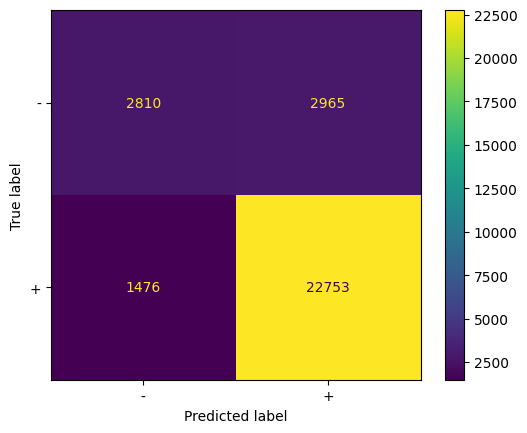

Precision per class:
 [0.65562296 0.8847111 ]
Recall per class:
 [0.48658009 0.93908127]
F1 Score per class:
 [0.55859259 0.91108575]
Weighted F1 Score: 0.8432398626237092


In [7]:
train_texts, test_texts, train_labels, test_labels = train_test_split(x_Review, y_Votes, test_size=0.3)
classifier = MultinomialNB(alpha=0.1)
classifier.fit(train_texts, train_labels)
y_pred = classifier.predict(test_texts)
metrics(test_labels, y_pred,'MultinomialNB Classic',results_list)

we now try to undersample the data to see if we can increase the precision and recall of the data 

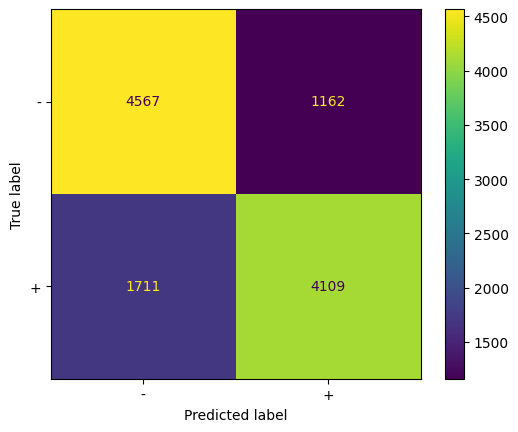

Precision per class:
 [0.72746097 0.77954847]
Recall per class:
 [0.79717228 0.70601375]
F1 Score per class:
 [0.76072291 0.74096114]
Weighted F1 Score: 0.7507641695033044


In [8]:
x_Review_undersampled , y_Votes_undersampled  = undersample_data(x_Review,y_Votes)
train_texts, test_texts, train_labels, test_labels = train_test_split(x_Review_undersampled, y_Votes_undersampled, test_size=0.3)

classifier = MultinomialNB(alpha=0.1)
classifier.fit(train_texts, train_labels)
y_pred = classifier.predict(test_texts)

metrics(test_labels, y_pred,'MultinomialNB Undersampled',results_list)
 

Now we are going to try to Oversample to see if we are capable of increasing the precision of our modal 

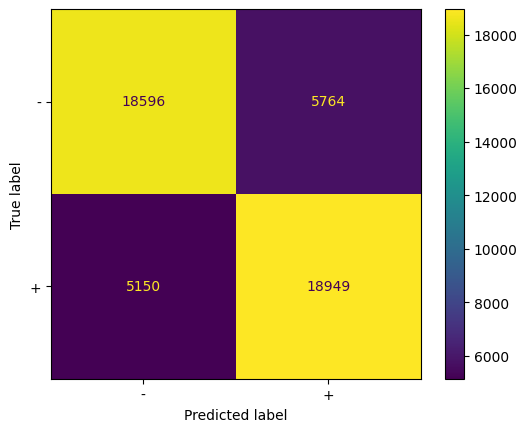

Precision per class:
 [0.78312137 0.76676243]
Recall per class:
 [0.76338259 0.78629819]
F1 Score per class:
 [0.77312601 0.77640744]
Weighted F1 Score: 0.7747578902120621


In [9]:
x_Review_oversampled , y_Votes_oversampled   = oversample_data(x_Review,y_Votes)
train_texts, test_texts, train_labels, test_labels = train_test_split(x_Review_oversampled, y_Votes_oversampled, test_size=0.3)

classifier = MultinomialNB(alpha=0.1)
classifier.fit(train_texts, train_labels)
y_pred = classifier.predict(test_texts)

metrics(test_labels, y_pred,'MultinomialNB Oversampled',results_list )


In [10]:
Review = [str(i) for i in dataset["review"]]
Votes = [int(i) for i in dataset["voted_up"]]
train_texts, test_texts, train_labels, test_labels = train_test_split(Review, Votes, test_size=0.3)

faire le data set classique


In [11]:
# model_name : 'bert-base-uncased'
classifier_bert = BertClassifier('./models/bert_model.pth')
classifier_bert.train(train_texts, train_labels)



Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly i

Loading saved model...
Model loaded successfully.


In [12]:
all_labels, all_predictions = classifier_bert.evaluate(test_texts, test_labels)
classifier_bert.save_incorrect_predictions(test_texts, all_labels, all_predictions,'./prediction/incorrect_bert_model.csv')



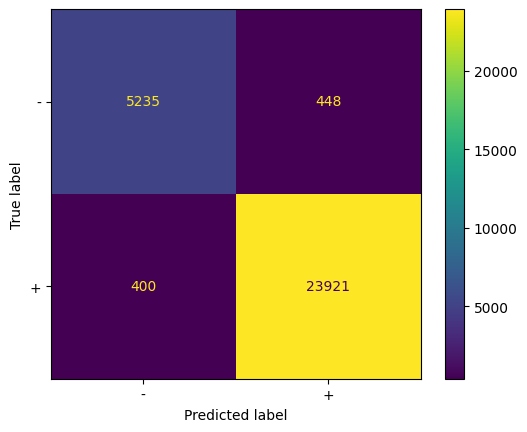

Precision per class:
 [0.92901508 0.98161599]
Recall per class:
 [0.9211684  0.98355331]
F1 Score per class:
 [0.9250751  0.98258369]
Weighted F1 Score: 0.971691100980289


In [13]:
metrics(all_labels, all_predictions,'Bert',results_list )

undersampling the data to see the distribution of bert 

In [14]:
Review = np.array([str(i) for i in dataset["review"]])
Votes = np.array([int(i) for i in dataset["voted_up"]])

Review = Review.reshape(-1, 1)
Votes = Votes.reshape(-1, 1)

# Undersample the data using your function
review_undersampled, labels_unsampled = undersample_data(Review, Votes)


train_texts, test_texts, train_labels, test_labels = train_test_split(review_undersampled,labels_unsampled, test_size=0.3)

train_texts = train_texts.flatten()
test_texts = test_texts.flatten()



training the Undersampled model

In [15]:

classifier_bert_undersampled = BertClassifier('./models/bert_model_undersampled.pth')
classifier_bert_undersampled.train(train_texts, train_labels)


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly i

Loading saved model...
Model loaded successfully.


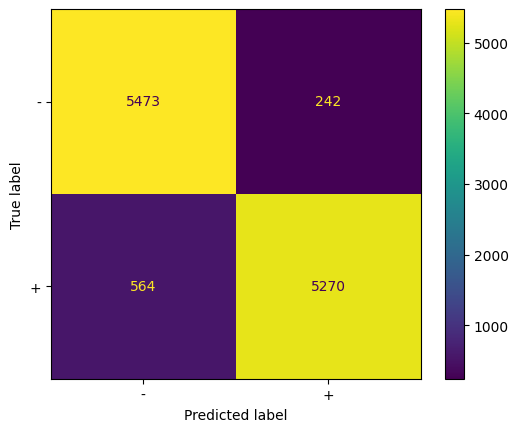

Precision per class:
 [0.90657611 0.95609579]
Recall per class:
 [0.95765529 0.90332533]
F1 Score per class:
 [0.93141593 0.92896175]
Weighted F1 Score: 0.9301761950756156


In [16]:
all_labels, all_predictions = classifier_bert_undersampled.evaluate(test_texts, test_labels)
classifier_bert_undersampled.save_incorrect_predictions(test_texts, all_labels, all_predictions,'./prediction/incorrect_bert_model_unsampled.csv')

metrics(all_labels, all_predictions,'Bert undersampled',results_list )


Now we are training Roberta Model to see if the results are better 

In [17]:
Review = [str(i) for i in dataset["review"]]
Votes = [int(i) for i in dataset["voted_up"]]

train_texts, test_texts, train_labels, test_labels = train_test_split(Review, Votes, test_size=0.3)



In [18]:
# model_name : 'RobertA_Model'
classifier_RobertA = RobertaClassifier('./models/RobertA_Model.pth')
classifier_RobertA.train(train_texts, train_labels)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should pr

Loading saved model...
Model loaded successfully.


In [19]:
all_labels, all_predictions = classifier_RobertA.evaluate(test_texts, test_labels)
classifier_RobertA.save_incorrect_predictions(test_texts, all_labels, all_predictions,'./prediction/incorrect_Roberta_model.csv')



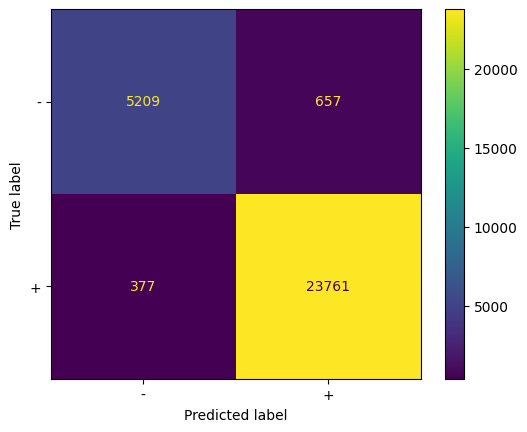

Precision per class:
 [0.93250985 0.97309362]
Recall per class:
 [0.88799864 0.98438147]
F1 Score per class:
 [0.90971009 0.978705  ]
Weighted F1 Score: 0.9652159949721794


In [20]:
metrics(all_labels, all_predictions,'RobertA',results_list )


In [21]:
Review = np.array([str(i) for i in dataset["review"]])
Votes = np.array([int(i) for i in dataset["voted_up"]])

Review = Review.reshape(-1, 1)
Votes = Votes.reshape(-1, 1)

review_undersampled, labels_unsampled = undersample_data(Review, Votes)


train_texts, test_texts, train_labels, test_labels = train_test_split(review_undersampled,labels_unsampled, test_size=0.3)

train_texts = train_texts.flatten()
test_texts = test_texts.flatten()

In [22]:
classifier_RobertA_Undersampled = RobertaClassifier('./models/RobertA_Model_Undersampled.pth')
classifier_RobertA_Undersampled.train(train_texts, train_labels)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should pr

Loading saved model...
Model loaded successfully.


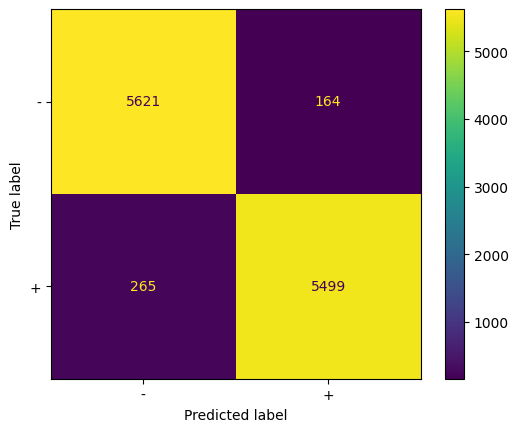

Precision per class:
 [0.95497791 0.97104008]
Recall per class:
 [0.97165082 0.95402498]
F1 Score per class:
 [0.96324222 0.96245734]
Weighted F1 Score: 0.9628504946952244


In [23]:
all_labels, all_predictions = classifier_RobertA_Undersampled.evaluate(test_texts, test_labels)
classifier_RobertA_Undersampled.save_incorrect_predictions(test_texts, all_labels, all_predictions,'./prediction/incorrect_Roberta_model_undersampled.csv')

metrics(all_labels, all_predictions,'RobertA Undersampled',results_list )

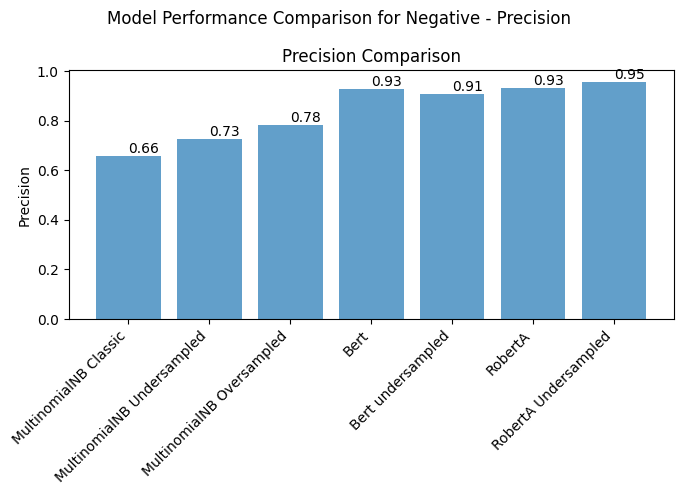

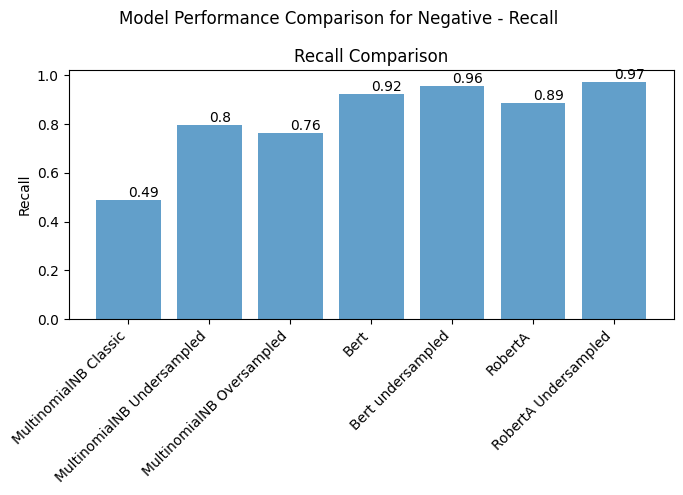

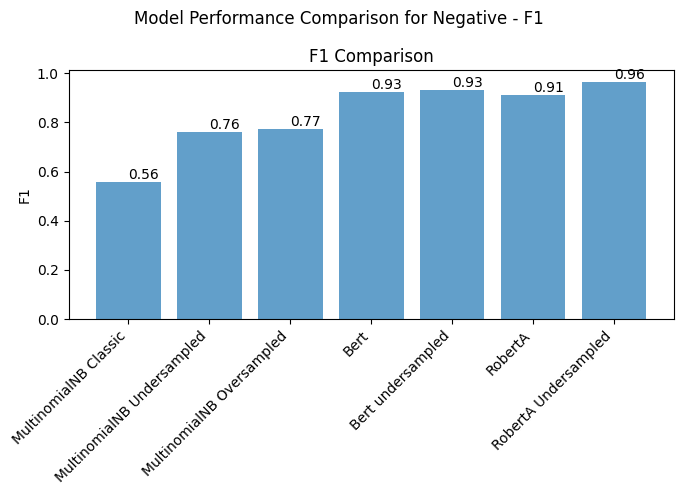

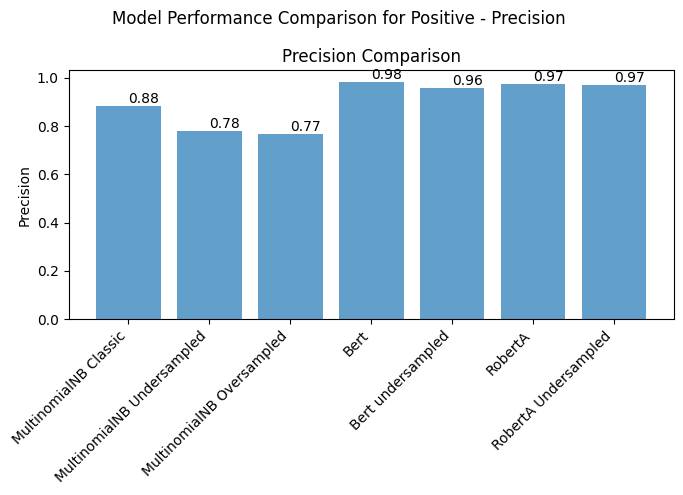

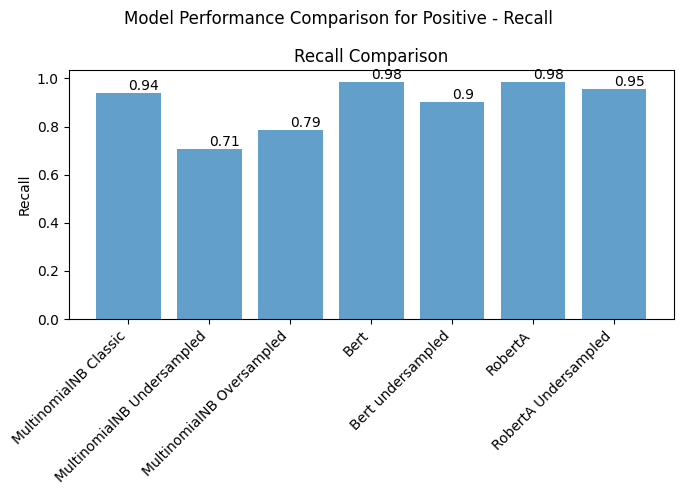

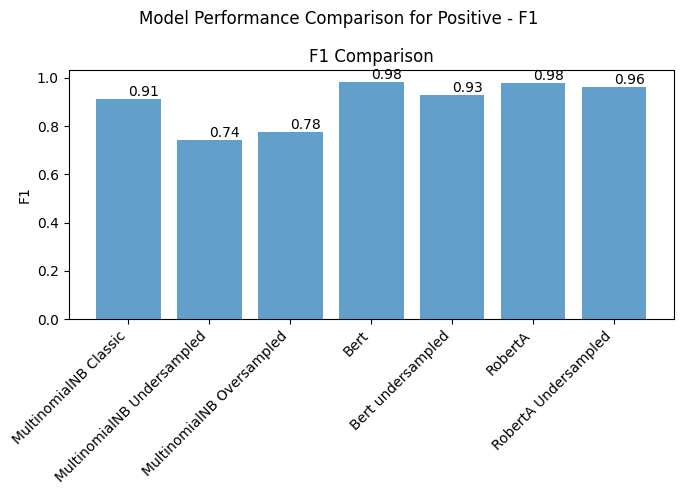

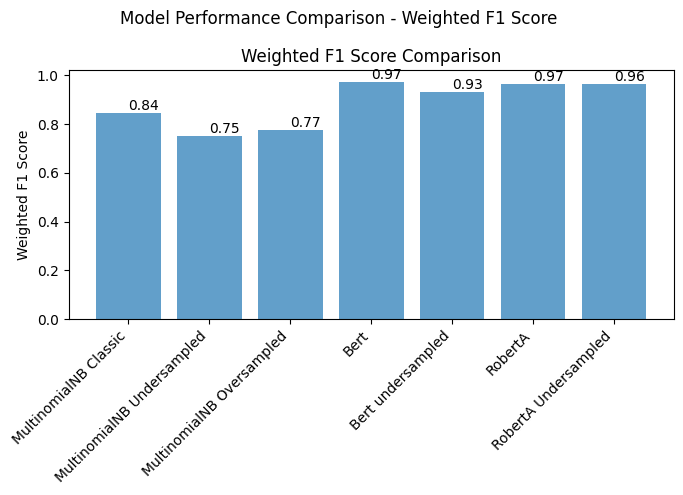

In [24]:
plot_model_comparisons(results_list)

Now we created a new dats set from Kaggle to see if our models work well with different data sets to make sure we had no data leakage as well as geenralizing our results 

In [25]:
dataset_test = pd.read_csv("./balanced_test_score.csv")
dataset_test.head()
commondataset=[]

preprocessing the data for the naive bayers

In [26]:
documents_test = []
import multiprocessing

max_processes = multiprocessing.cpu_count()

for doc in nlp.pipe([str(r) for r in dataset_test['review']] , n_process=max_processes-1, batch_size=1000):
    documents_test.append(' '.join([tok.lemma_ for tok in doc if not tok.is_stop and tok.is_alpha]))

In [27]:
cv = CountVectorizer(max_features = 1500)
x_Review = cv.fit_transform(documents).toarray()
y_Votes = [int(i) if int(i)==1 else 0 for i in dataset["voted_up"]]
 
x_Review_undersampled , y_Votes_undersampled  = undersample_data(x_Review,y_Votes)

x_Review_test= cv.fit_transform(documents_test).toarray()
y_Votes_test = [int(i) if int(i)==1 else 0 for i in dataset_test["voted_up"]]
train_texts, _, train_labels, _ = train_test_split(x_Review_undersampled, y_Votes_undersampled, test_size=0.1)
_, test_texts, _,test_labels = train_test_split(x_Review_test, y_Votes_test, test_size=0.99)


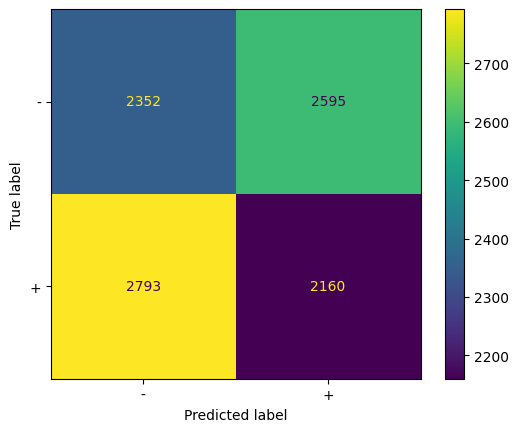

Precision per class:
 [0.45714286 0.45425868]
Recall per class:
 [0.47543966 0.43609933]
F1 Score per class:
 [0.46611177 0.44499382]
Weighted F1 Score: 0.45554639623587495


In [28]:

classifier = MultinomialNB(alpha=0.1)
classifier.fit(train_texts, train_labels)
y_pred = classifier.predict(test_texts)

metrics(test_labels, y_pred,'MultinomialNB Classic_test',commondataset)

In [29]:
x_Review = [str(i) for i in dataset_test["review"]]
y_Votes = [int(i) if int(i)==1 else 0 for i in dataset_test["voted_up"]]
train_texts, test_texts, train_labels,test_labels = train_test_split(x_Review, y_Votes, test_size=0.95)

In [30]:
classifier_RobertA_Undersampled = RobertaClassifier('./models/RobertA_Model_Undersampled.pth')
classifier_RobertA_Undersampled.train(train_texts, train_labels)

classifier_RobertA = RobertaClassifier('./models/RobertA_Model.pth')
classifier_RobertA.train(train_texts, train_labels)

classifier_bert_undersampled = BertClassifier('./models/bert_model_undersampled.pth')
classifier_bert_undersampled.train(train_texts, train_labels)

classifier_bert = BertClassifier('./models/bert_model.pth')
classifier_bert.train(train_texts, train_labels)


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should pr

Loading saved model...
Model loaded successfully.


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should pr

Loading saved model...
Model loaded successfully.


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly i

Loading saved model...
Model loaded successfully.


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly i

Loading saved model...
Model loaded successfully.


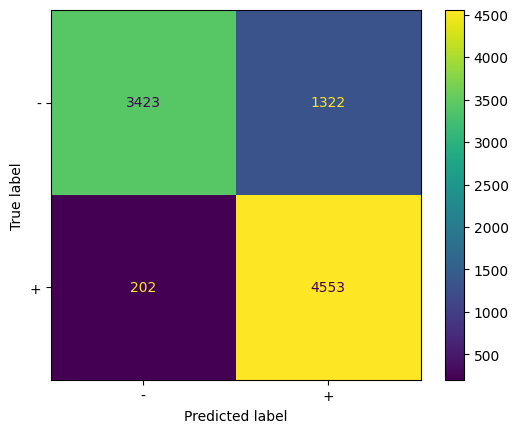

Precision per class:
 [0.94427586 0.77497872]
Recall per class:
 [0.72139094 0.9575184 ]
F1 Score per class:
 [0.81792115 0.85663217]
Weighted F1 Score: 0.8372970342484946


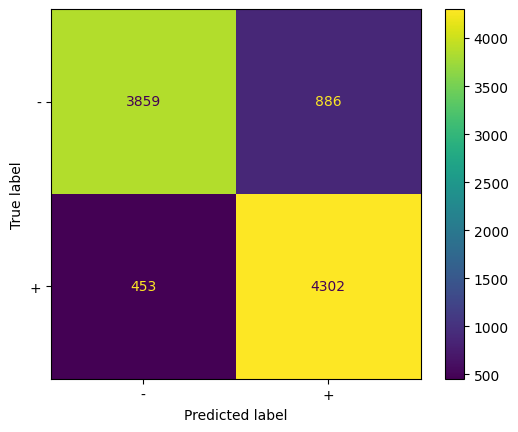

Precision per class:
 [0.89494434 0.82922128]
Recall per class:
 [0.81327713 0.90473186]
F1 Score per class:
 [0.85215855 0.86533239]
Weighted F1 Score: 0.8587524066248179


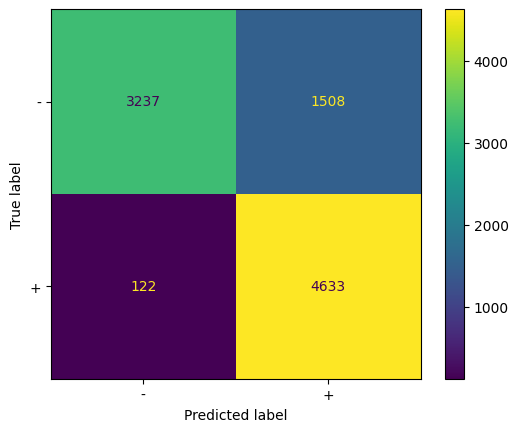

Precision per class:
 [0.96367967 0.75443739]
Recall per class:
 [0.68219178 0.9743428 ]
F1 Score per class:
 [0.79886476 0.85040382]
Weighted F1 Score: 0.8246614138504107


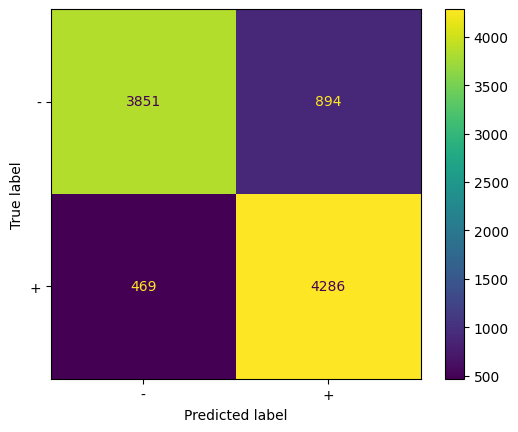

Precision per class:
 [0.89143519 0.82741313]
Recall per class:
 [0.81159115 0.90136698]
F1 Score per class:
 [0.84964148 0.86280825]
Weighted F1 Score: 0.85623179581262


In [31]:
all_labels_b, all_predictions_b = classifier_bert.evaluate(test_texts, test_labels)
all_labels_bu, all_predictions_bu = classifier_bert_undersampled.evaluate(test_texts, test_labels)
all_labels_r, all_predictions_r = classifier_RobertA.evaluate(test_texts, test_labels)
all_labels_ru, all_predictions_ru = classifier_RobertA_Undersampled.evaluate(test_texts, test_labels) 

metrics(all_labels_b, all_predictions_b,'Bert',commondataset)
metrics(all_labels_bu, all_predictions_bu,'Bert Undersampled',commondataset)
metrics(all_labels_r, all_predictions_r,'Roberta',commondataset )
metrics(all_labels_ru, all_predictions_ru,'Roberta Undersampled',commondataset)

classifier_bert.save_incorrect_predictions(test_texts, all_labels_b, all_predictions_b,'./prediction/incorrect_bert_commonTest.csv')
classifier_bert_undersampled.save_incorrect_predictions(test_texts, all_labels_bu, all_predictions_bu,'./prediction/incorrect_bertU_commonTest.csv')
classifier_RobertA.save_incorrect_predictions(test_texts, all_labels, all_predictions_r,'./prediction/incorrect_Roberta_commonTest.csv')
classifier_RobertA_Undersampled.save_incorrect_predictions(test_texts, all_labels_ru, all_predictions_ru,'./prediction/incorrect_RobertaU_commonTest.csv')


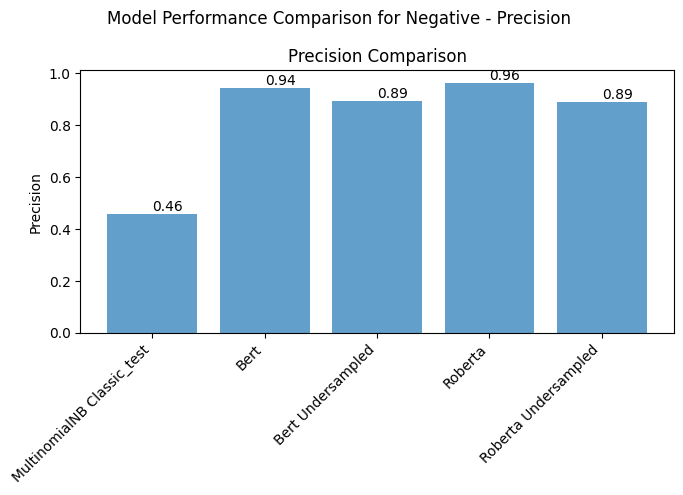

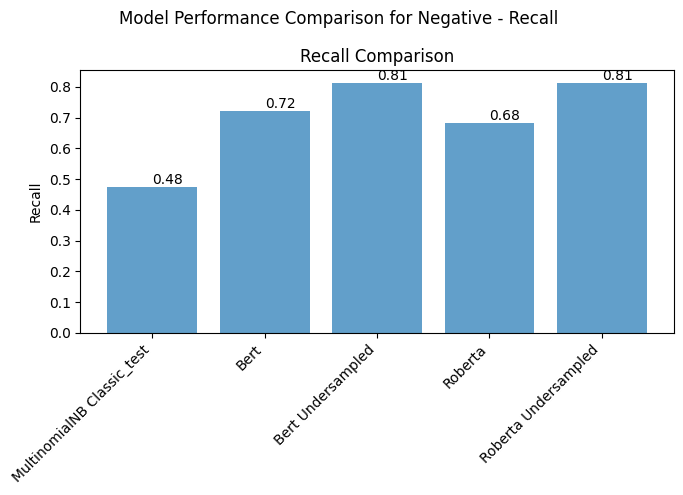

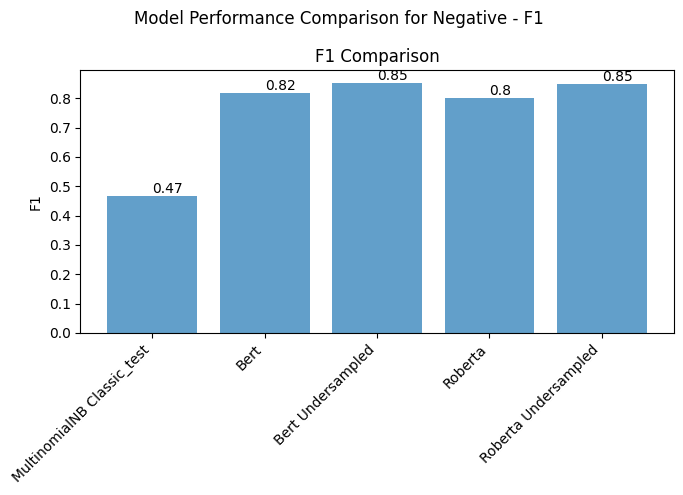

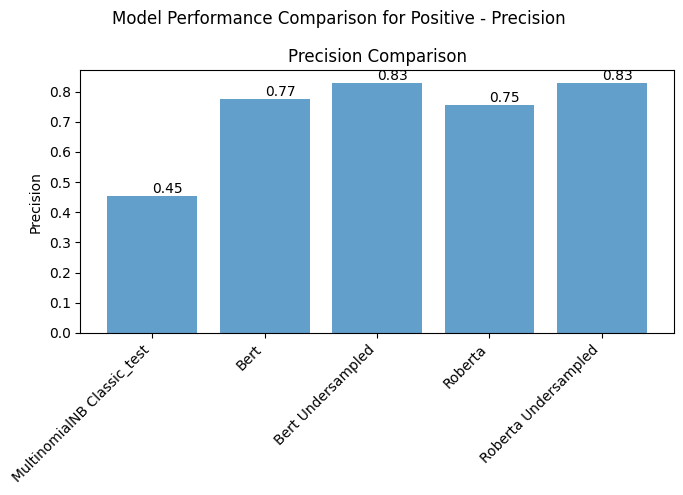

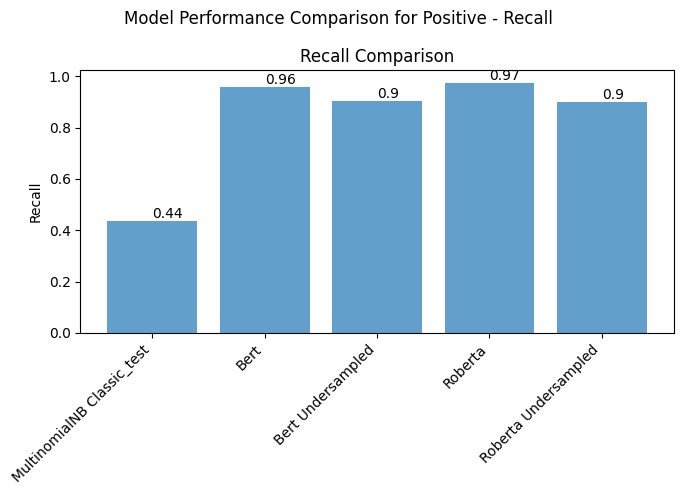

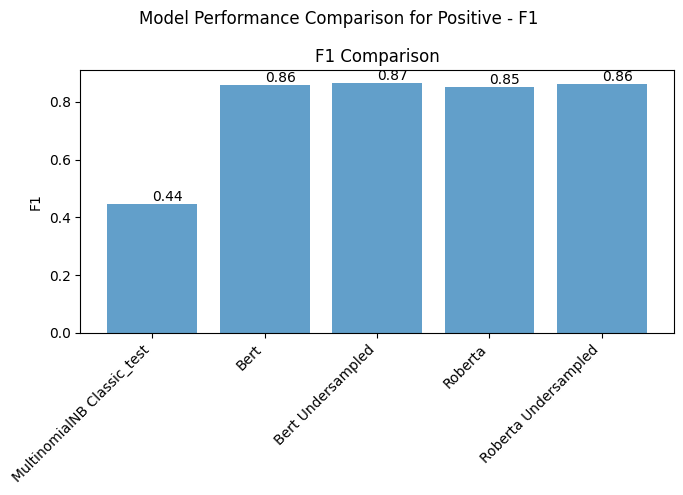

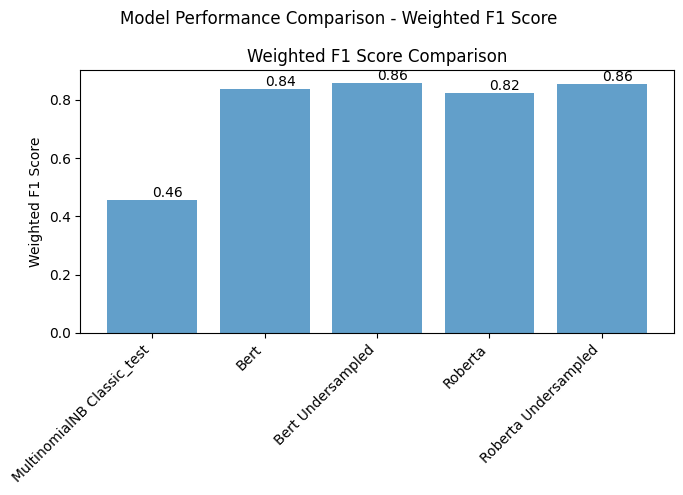

In [32]:
plot_model_comparisons(commondataset)

In [33]:
print(commondataset)
print(results_list)


[{'model': 'MultinomialNB Classic_test', 'precision': array([0.45714286, 0.45425868]), 'recall': array([0.47543966, 0.43609933]), 'f1': array([0.46611177, 0.44499382]), 'weighted_f1': 0.45554639623587495}, {'model': 'Bert', 'precision': array([0.94427586, 0.77497872]), 'recall': array([0.72139094, 0.9575184 ]), 'f1': array([0.81792115, 0.85663217]), 'weighted_f1': 0.8372970342484946}, {'model': 'Bert Undersampled', 'precision': array([0.89494434, 0.82922128]), 'recall': array([0.81327713, 0.90473186]), 'f1': array([0.85215855, 0.86533239]), 'weighted_f1': 0.8587524066248179}, {'model': 'Roberta', 'precision': array([0.96367967, 0.75443739]), 'recall': array([0.68219178, 0.9743428 ]), 'f1': array([0.79886476, 0.85040382]), 'weighted_f1': 0.8246614138504107}, {'model': 'Roberta Undersampled', 'precision': array([0.89143519, 0.82741313]), 'recall': array([0.81159115, 0.90136698]), 'f1': array([0.84964148, 0.86280825]), 'weighted_f1': 0.85623179581262}]
[{'model': 'MultinomialNB Classic', 